In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import localprojections as lp
import statsmodels.api as sm
from scipy.stats import norm

# What is a Local Projection?
Local Projections (LP), introduced by Jordà (2005), are an econometric method used to estimate the dynamic response of a variable (e.g., GDP, inflation) to a shock over multiple time horizons. 

For each forecast horizon $( h = 0, 1, \dots, H )$, LPs estimate a regression of the form:

$$
y_{t+h} = \alpha_h + \theta_h z_t + \gamma_h^\top X_t + \varepsilon_{t+h}
$$

where:
- $( y_{t+h})$: response variable at future horizon $( h ),$
- $( z_t)$: shock variable at time $( t )$,
- $( X_t)$: vector of control variables (lags, dummies, etc.),
- $( \theta_h )$: impulse response at horizon $( h )$.

LPs are attractive due to their simplicity and flexibility, especially compared to VARs.

The goal of this notebook is to replicate Figure 5 from Jordà (2005), which shows impulse response 
functions (IRFs) of three macroeconomic variables:
- Output Gap (GDP_gap),
- Inflation (Infl),
- Federal Funds Rate (FF),

in response to shocks in each of these variables using the LP method. We use quarterly U.S. data and estimate horizon-specific IRFs with two lags of all variables.

In [2]:
# Load the data
data = pd.read_csv("lplin_data.csv")
Y = ['GDP_gap', 'Infl', 'FF']  # endogenous variables

## Econometric Reasoning Behind LPs
**LPs as a sequence of conditional expectations**
$$
\theta_h = \frac{\partial \mathbb{E}[y_{t+h}|shock_t]}{\partial shock_t}
$$
- Interpretation: $\theta_h$ captures the marginal effect of a shock at time $t$ on the expected value of $y$ at horizon $t + h$;
- Estimating impulse responses as derivatives of conditional expectations avoids assumptions about the full dynamic system;
- Each horizon h is treated as a separate estimation problem, allowing the response to evolve flexibly over time.

| Feature             | VARs                   | Local Projections (LPs) |
|---------------------|------------------------|--------------------------|
| Estimation          | System of equations    | Separate regressions     |
| Flexibility         | Less                   | More                     |
| Misspecification    | Sensitive              | More robust              |
| Long horizon noise  | Less noisy (if correct)| More noisy               |
| Ease of extension   | More complex           | Easier                   |

In [3]:
def Local_Projections(
    data,
    Y,                # List of all system variables (e.g., ['GDP_gap','Infl','FF'])
    response,         # List of response variables for which IRFs are estimated
    horizon,          # Max forecast horizon (0..horizon)
    lags,             # Number of lags included for each variable
    newey_lags,       # Maxlags for Newey-West HAC SE
    ci_width,         # E.g. 0.95 for a 95% CI
    shock=None,       # If not None, only extract IRFs for these shock vars
    store_internals=False  # If True, also store design matrix, fitted, residuals for bootstrap
):
    """
    Estimates IRFs by local projections for each horizon h=0..H, each response in 'response',
    building a design matrix with 0..lags for each var in Y. Optionally stores 'internals'
    for each (r, h) so that we can do a bootstrap later without re-running the entire code.

    Returns
    -------
    results : dict
        results[resp][shock] = dict of arrays: 'irf', 'lower', 'upper' (length horizon+1)
    horizon_internals : dict (only if store_internals=True)
        horizon_internals[resp][h] = {
            'X_reg': DataFrame of regressors,
            'fitted': array of fitted values,
            'resid': array of residuals
        }
    """
    if shock is None:
        shock = Y.copy()

    # Prepare data structures for IRF results
    z_val = norm.ppf(1 - (1 - ci_width)/2)
    results = {
        r: {s: {"irf": [], "lower": [], "upper": []} for s in shock}
        for r in response
    }

    # Optionally store internals if store_internals == True
    horizon_internals = {}
    if store_internals:
        horizon_internals = {
            r: {h: {} for h in range(horizon+1)}
            for r in response
        }

    # Loop over horizons and response variables
    for h in range(horizon+1):
        for r in response:
            # Dependent variable: y_{t+h}
            y_shift = data[r].shift(-h)

            # Build the design matrix: for each var in Y, include lag0..lags
            X_parts = []
            col_names = []
            for var in Y:
                for lag_i in range(lags+1):
                    X_parts.append(data[var].shift(lag_i))
                    col_names.append(f"{var}_lag{lag_i}")
            X = pd.concat(X_parts, axis=1)
            X.columns = col_names

            # Add constant
            X = sm.add_constant(X)

            # Align, drop missing
            df_reg = pd.concat([y_shift, X], axis=1).dropna()
            y_reg = df_reg.iloc[:,0]
            X_reg = df_reg.iloc[:,1:]  # keep as DataFrame for column names

            # OLS with NW
            model = sm.OLS(y_reg, X_reg).fit(cov_type='HAC', cov_kwds={'maxlags': newey_lags})

            # Save fitted & residual if needed
            if store_internals:
                horizon_internals[r][h]['X_reg'] = X_reg
                horizon_internals[r][h]['fitted'] = model.fittedvalues.values
                horizon_internals[r][h]['resid']  = model.resid.values

            # Extract IRFs for each shock variable
            for s in shock:
                col_shock = f"{s}_lag0"
                coef = model.params.get(col_shock, np.nan)
                se   = model.bse.get(col_shock, np.nan)

                results[r][s]["irf"].append(coef)
                results[r][s]["lower"].append(coef - z_val * se)
                results[r][s]["upper"].append(coef + z_val * se)

    # Convert to arrays
    for r in response:
        for s in shock:
            for key in ["irf","lower","upper"]:
                results[r][s][key] = np.array(results[r][s][key])

    # Return results. If store_internals, also return horizon_internals
    if store_internals:
        return results, horizon_internals
    else:
        return results, None

def show_irfs(horizon, irf_results, shock_vars, response_vars, bootstrap_draws: dict = None):
    if bootstrap_draws == None:
        horizons_arr = np.arange(horizon+1)
        n_shocks = len(shock_vars)
        fig, axes = plt.subplots(1, n_shocks, figsize=(5*n_shocks, 4), sharey=True)
        if n_shocks == 1:
            axes = [axes]
        for i, s in enumerate(shock_vars):
            ax = axes[i]
            irf_curve = irf_results[response_vars[0]][s]["irf"]
            lower_curve = irf_results[response_vars[0]][s]["lower"]
            upper_curve = irf_results[response_vars[0]][s]["upper"]
            ax.plot(horizons_arr, irf_curve, marker='o', label=f"IRF to {s} shock")
            ax.fill_between(horizons_arr, lower_curve, upper_curve, color='gray', alpha=0.3, label="95% CI")
            ax.axhline(0, color='black', linestyle='--', linewidth=1)
            ax.set_xlabel("Horizon")
            ax.set_title(f"Response of {response_vars[0]} to {s} shock")
            ax.legend()
            ax.grid(True)
        axes[0].set_ylabel("Impulse Response")
        plt.suptitle(f"IRFs of {response_vars[0]} to Shocks in All Variables")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    else:
        horizons_arr = np.arange(horizon+1)
        n_shocks = len(shock_vars)
        fig, axes = plt.subplots(1, n_shocks, figsize=(5*n_shocks, 4), sharey=True)
        if n_shocks == 1:
            axes = [axes]
        for i, s in enumerate(shock_vars):
            ax = axes[i]
            irf_curve = irf_results[response_vars[0]][s]["irf"]
            lower_curve = irf_results[response_vars[0]][s]["lower"]
            upper_curve = irf_results[response_vars[0]][s]["upper"]
            # The bootstrap distribution, shape (B, horizon+1)
            draws = bootstrap_draws[response_vars[0]][s]
            # percentile intervals
            alpha = 0.05
            lower_q = 100*(alpha/2)
            upper_q = 100*(1-alpha/2)
            irf_lower_bs = np.percentile(draws, lower_q, axis=0)
            irf_upper_bs = np.percentile(draws, upper_q, axis=0)

            ax.plot(horizons_arr, irf_curve, marker='o', label=f"IRF to {s} shock")
            ax.fill_between(horizons_arr, lower_curve, upper_curve, color='gray', alpha=0.3, label="95% CI")
            ax.axhline(0, color='black', linestyle='--', linewidth=1)
            # bootstrap intervals in orange
            ax.plot(horizons_arr, irf_curve, linestyle=':', color='red', label='Bootstrap percentile CI')
            ax.fill_between(horizons_arr, irf_lower_bs, irf_upper_bs, color='red', alpha=0.2)
            ax.axhline(0, color='black', linestyle='--', linewidth=1)
            ax.set_xlabel("Horizon")
            ax.set_title(f"Response of {response_vars[0]} to {s} shock")
            ax.legend()
            ax.grid(True)
        axes[0].set_ylabel("Impulse Response")
        plt.suptitle(f"IRFs of {response_vars[0]} to Shocks in All Variables")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

## What Do You Expect?

Before we run the local projection for GDP_gap to a monetary policy shock (FF), quick thought:

**Do you expect the GDP_gap to increase or decrease after a rate hike? Why?**

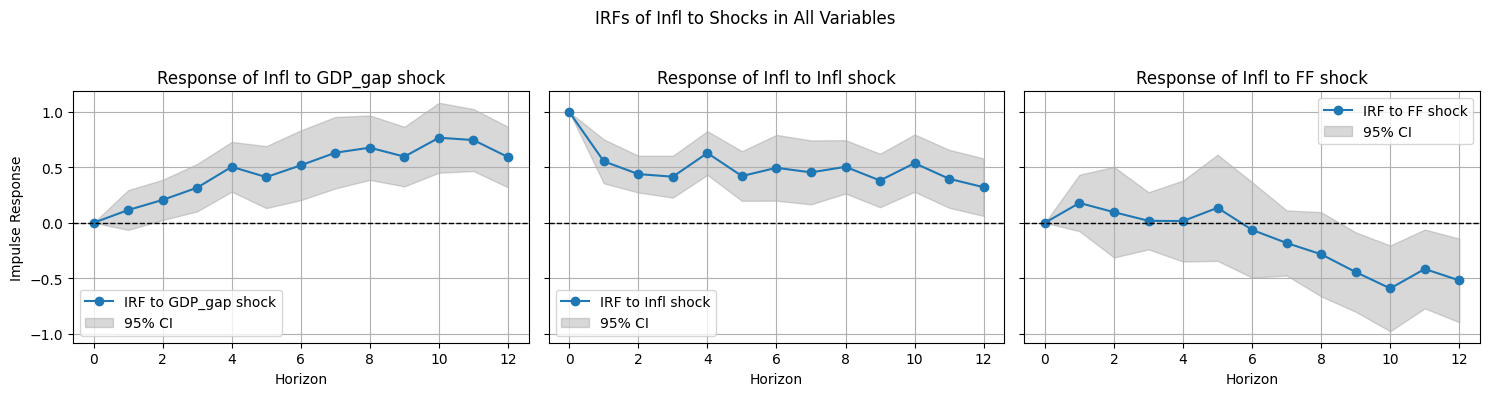

In [4]:
# Convert columns to list (if needed)
Y = list(data.columns)  # e.g. ['GDP_gap', 'Infl', 'FF']

# Here we want to estimate the IRFs for the response variable 'Infl'
# (i.e., how Inflation responds) to shocks from each variable in Y.
response_vars = ['Infl']
shock_vars = Y   # shocks from all variables in the system

# Set replication parameters:
horizon = 12      # forecast horizon: 0,1,...,12
lags = 2          # number of lags to include for each variable
newey_lags = 2    # HAC lags for Newey-West standard errors
ci_width = 0.95   # 95% confidence interval

# Estimate IRFs using our custom function (Step 1)
irf_results, _ = Local_Projections(data=data, 
                                    Y=Y, 
                                    response=response_vars, 
                                    horizon=horizon, 
                                    lags=lags, 
                                    newey_lags=newey_lags, 
                                    ci_width=ci_width, 
                                    shock=shock_vars)

show_irfs(horizon, irf_results, shock_vars, response_vars, )

In [5]:
try_shock = data.drop(columns=['Infl'])

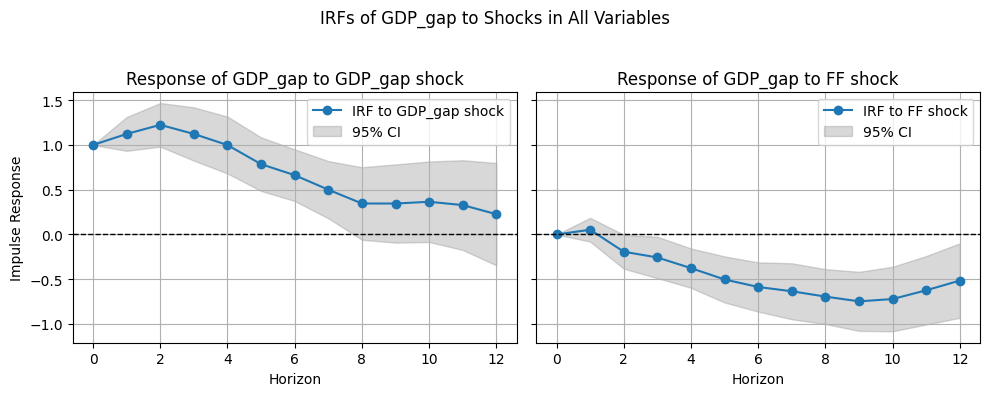

In [6]:
# Convert columns to list (if needed)
Y = list(try_shock.columns)  # e.g. ['GDP_gap', 'Infl', 'FF']

# (i.e., how Inflation responds) to shocks from each variable in Y.
response_vars = ['GDP_gap']
shock_vars = Y   # shocks from all variables in the system

# Set replication parameters:
horizon = 12      # forecast horizon: 0,1,...,12
lags = 1          # number of lags to include for each variable
newey_lags = 2    # HAC lags for Newey-West standard errors
ci_width = 0.95   # 95% confidence interval

# Estimate IRFs using our custom function (Step 1)
irf_results, _ = Local_Projections(data=try_shock, 
                                    Y=Y, 
                                    response=response_vars, 
                                    horizon=horizon, 
                                    lags=lags, 
                                    newey_lags=newey_lags, 
                                    ci_width=ci_width, 
                                    shock=shock_vars)

show_irfs(horizon, irf_results, shock_vars, response_vars)

In [7]:
def bootstrap_LP(data, Y, response, horizon, lags, newey_lags,ci_width=0.95, shock=None, B=500, seed=None):
    """
    1) Call Local_Projections(..., store_internals=True) to get original IRFs + design/resid
    2) For each horizon h and response var r, do the residual bootstrap
    3) Return (original_coefs, boot_draws)
    """

    if seed is not None:
        np.random.seed(seed)

    # Step 1: get original IRFs plus the internals
    lp_results, horizon_internals = Local_Projections(
        data=data, Y=Y, response=response,
        horizon=horizon, lags=lags, newey_lags=newey_lags,
        ci_width=ci_width, shock=shock,
        store_internals=True
    )

    # 'lp_results' is the same dictionary of IRFs, lower, upper from NW
    # 'horizon_internals' contains X_reg, fitted, resid for each horizon

    # Let's build a structure for the boot_coefs: boot_coefs[r][s] = (B, horizon+1)
    if shock is None:
        shock = Y
    boot_coefs = {
        r: {s: np.zeros((B, horizon+1)) for s in shock}
        for r in response
    }

    # Step 2: For each replication b, horizon h, response r:
    for b_i in range(B):
        for r in response:
            for h_i in range(horizon+1):
                # retrieve design & residual
                X_reg = horizon_internals[r][h_i]['X_reg']
                fitted_vals = horizon_internals[r][h_i]['fitted']
                resid = horizon_internals[r][h_i]['resid']
                n = len(resid)

                # resample residuals
                e_star = np.random.choice(resid, size=n, replace=True)
                y_star = fitted_vals + e_star

                # re-estimate OLS
                model_b = sm.OLS(y_star, X_reg).fit(cov_type='HAC', cov_kwds={'maxlags': newey_lags})

                # store shock coefficients
                for s in shock:
                    col_shock = f"{s}_lag0"
                    boot_coefs[r][s][b_i, h_i] = model_b.params.get(col_shock, np.nan)

    return lp_results, boot_coefs

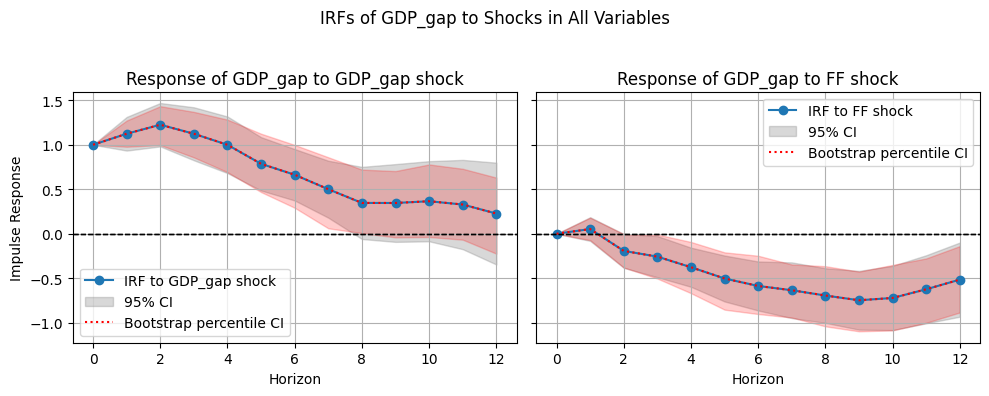

In [8]:
# number of bootstrap replications
B = 500

# 1) get NW-based IRFs + do store_internals
lp_results, boot_draws = bootstrap_LP(data, Y, response_vars, horizon, lags, newey_lags, ci_width=ci_width, shock=shock_vars, B=B, seed=123)

show_irfs(horizon, irf_results, shock_vars, response_vars, boot_draws)

In [9]:
from statsmodels.datasets import grunfeld
df = grunfeld.load_pandas().data # import the Grunfeld investment data set
df = df[df['firm'] == 'General Motors'] # keep only one entity (as an example of a single entity time series setting)
df = df.set_index(['year']) # set time variable as index

endog = ['invest', 'value', 'capital'] # cholesky ordering: invest --> value --> capital
response = endog.copy() # estimate the responses of all variables to shocks from all variables
irf_horizon = 8 # estimate IRFs up to 8 periods ahead
opt_lags = 2 # include 2 lags in the local projections model
opt_cov = 'robust' # HAC standard errors
opt_ci = 0.95 # 95% confidence intervals

# Use TimeSeriesLP for the single entity case
irf = lp.TimeSeriesLP(data=df, # input dataframe
                      Y=endog, # variables in the model
                      response=response, # variables whose IRFs should be estimated
                      horizon=irf_horizon, # estimation horizon of IRFs
                      lags=opt_lags, # lags in the model
                      newey_lags=2, # maximum lags when estimating Newey-West standard errors
                      ci_width=opt_ci # width of confidence band
                      )
irfplot = lp.IRFPlot(irf=irf, # take output from the estimated model
                     response=['invest'], # plot only response of invest ...
                     shock=endog, # ... to shocks from all variables
                     n_columns=2, # max 2 columns in the figure
                     n_rows=2, # max 2 rows in the figure
                     maintitle='Single Entity Time Series LP: IRFs of Investment', # self-defined title of the IRF plot
                     show_fig=True, # display figure (from plotly)
                     save_pic=False # don't save any figures on local drive
                     )

c:\Users\valte\Dropbox (Personal)\Valter Nóbrega\Projects\Immigration, Inequality and Welfare - A Skill-Distribution Perspective\Code\Python Code\.venv\Lib\site-packages\localprojections\lp.py:794: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  irf_full = pd.concat([irf_full, irf], axis=0)  # top to bottom concat
c:\Users\valte\Dropbox (Personal)\Valter Nóbrega\Projects\Immigration, Inequality and Welfare - A Skill-Distribution Perspective\Code\Python Code\.venv\Lib\site-packages\localprojections\lp.py:1520: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user